# 3D Growing Neural Cellular Automaton


In [ ]:
#@title Required imports
import torch
import numpy as np
import pandas as pd

import cv2
from scipy import ndimage

import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
import matplotlib.gridspec as gridspec
import seaborn as sns

from IPython.core.display import display, HTML
from moviepy.editor import *

import os
import json
import time
from datetime import datetime
import shutil
import uuid

from tqdm.notebook import trange, tqdm
import gdown
from zipfile import ZipFile

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3178496/45929032 bytes (6.9%)7389184/45929032 bytes (16.1%)11395072/45929032 bytes (24.8%)15269888/45929032 bytes (33.2%)19193856/45929032 bytes (41.8%)23314432/45929032 bytes (50.8%)27508736/45929032 bytes (59.9%)31678464/45929032 bytes (69.0%)35848192/45929032 bytes (78.1%)39903232/45929032 bytes (86.9%)43581440/45929032 bytes (94.9%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

In [ ]:
device = torch.device("cuda")
device

device(type='cuda')

In [ ]:
#@title Utils functions

def download_from_drive(name: str, gdrive_id: str, unzip=True, quiet=True):
  if os.path.isfile(name):
    print("{} already downloaded.".format(name))
    return name

  url = "https://drive.google.com/uc?id={}".format(gdrive_id)
  output = "./" + name
  gdown.download(url, output, quiet=quiet)

  if unzip:
    with ZipFile("./" + name, "r") as f:
      f.extractall("./")

  return output

def dec_to_rgb(dec_color):
  return (dec_color // 256 // 256 % 256, dec_color // 256 % 256, dec_color % 256)

def rgb_to_hex(r, g, b):
  return ('#{:02X}{:02X}{:02X}').format(int(r), int(g), int(b))

def norm_rgb(input):
  input[:, :, :, :3] = input[:, :, :, :3] / 255.
  return input

def denorm_rgb(input):
  input[:, :, :, :3] = (input[:, :, :, :3] * 255).astype(np.int32)
  return input

def convert_size(size_bytes):
  import math
  if size_bytes == 0:
      return "0B"
  size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
  i = int(math.floor(math.log(size_bytes, 1024)))
  p = math.pow(1024, i)
  s = round(size_bytes / p, 2)
  return "%s %s" % (s, size_name[i])

def get_allocated_memory():
  return convert_size(torch.cuda.memory_allocated())

def save_model_state(id, epoch, params, model, optimizer, losses, pool, pool_losses, target_dir = "Tests"):
  # Save model
  torch.save(model.state_dict(), "model.pt")

  # Save loss
  df = pd.DataFrame([loss.cpu().detach().numpy() for loss in losses], columns=["loss"])
  df.to_csv("losses.csv")

  # Save params
  with open("params.json", "w") as f:
    params["epoch"] = epoch
    f.write(json.dumps(params))

  # Save optimizer state
  torch.save(optimizer.state_dict(), "optimizer.pt")

  # Save pool
  torch.save(pool, "pool.pt")
  torch.save(pool_losses, "pool_losses.pt")

  # Zip files
  zip_name = "{}.zip".format(id)

  zip = ZipFile(os.path.join(target_dir, zip_name), "w")

  zip.write("params.json")
  zip.write("losses.csv")
  zip.write("model.pt")
  zip.write("optimizer.pt")
  zip.write("pool.pt")
  zip.write("pool_losses.pt")

  zip.close()

  print("Saved model {} state at epoch {}".format(id, epoch))

def normalize_shape_name(shape_name):
  return shape_name.lower().replace(" ", "_")

# 3D Models and saved weights

# Google Drive ids of saved voxel models (.vox)
DRIVE_SHAPES_ID = {
    "Box with cross": "1HswEcAko2x7T0jqVdER-w8L60BDDsoYT",
    "Colored": "1tuMcmFuOetjg3esMbPZETVpVMZjVPm3S",
    "Dino": "1bUZUzsl82j6__DGn4hxyIxQRmALKtV40",
    "Snake": "1MshbyBKVzCzeVIJmK5eVUYDJGp7NIPuL",
    "Minecraft Pig": "137Jpx11yBeZMuJ_IulmCZtdd2eWTTEvZ",
    "Minecraft Chicken": "1oOjz251MIx8fTTuW4QvqQq7rUOYbWASO",
    "Minecraft Cow": "145bOevDpmkYlkSh1lpKMpINGKrZL_p3G",
    "Minecraft Dog": "1Q6pWq9hcrlnKSor6yajfyngSUVxLeVRg",
    "Tower": "1lCRyPqC7JVSIAta0Zg3PVKi0t26BE-g1",
    "Splash": "1YWuWRE9LQYaqxnqKVZ7FXSZBCeOzSaxl"
}

# Assigned id of models, used to resume the training
SAVED_MODELS_ID = {
  "Box with cross": "f1342303-ce6c-44f3-900b-0d38d7085efa",
  "Colored": "1338488b-9b55-45ce-9915-0589be03fa5b",
  "Dino": "4075fcf1-81e3-4f0a-8769-3da36c5e2390",
  "Snake": "3d6a9e07-7ec6-4e76-b3e6-8b287c42c6ef",
  "Minecraft Pig": "2277b675-ae11-4384-b924-958f4f2eae68",
  "Minecraft Chicken": "76adc41b-c4fa-41af-8bcc-649b07eeac1f",
  "Minecraft Cow": "4420bb01-ea35-44ce-8cef-aceac12ddcd7",
  "Minecraft Dog": "effb7c40-4cec-42d0-918b-b757d05255ae",
  "Tower": "424594eb-76ef-40d2-9123-630fb06a9857",
  "Splash": "1864c136-fae9-490a-a53e-9b641f356a56"
}

# Google Drive ids of pretrained models, ready to use
DRIVE_PRETRAINED_MODELS_ID = {
  "Box with cross": "1-0qmd3JSencnUM-4KsueU9Oiq0uwu20M",
  "Colored": "1HLDhKsavptq1z44jy67Sk3zSD853nS1Y",
  "Dino": "1WtohE12CVSDOLvjzLUa2X9bK78s5oE0O",
  "Snake": "1QQGQalpFNguli78d6KOS3Sdw5EdkWmED",
  "Minecraft Pig": "17Pmko5MpIK_zL7A7ogMgjaqfL_lAWJdK",
  "Minecraft Chicken": "1aNqqvm93WuLndr4Q4JM205ZwIO9AkzUA",
  "Minecraft Cow": "1jpfn0tqXBr28hvSRag7CZoE9mcWnxCMc",
  "Minecraft Dog": "1-0Amut-Wy1IeAaxnQWBLKAkDE5hkkAvW",
  "Tower": "1-6bYRJp6Rs8qR1ZM0gTr4vpQuGE2swWt",
  "Splash": "1-7JxzGfoTp0kpz3fxx-QwCOVIVkaJV3n"
}

In [ ]:
#@title Visualization code

# --- Plotly visualization ---

def create_voxel_mesh(x, y, z, color, opacity=True):
  r, g, b, a = np.clip(color, 0, 255)
  a = np.round(np.clip(a, 0, 1), 2) if opacity else 1
  
  rgba_str = "rgba({}, {}, {}, {})".format(r, g, b, a)

  mesh = go.Mesh3d(
      x=np.array([0, 0, 1, 1, 0, 0, 1, 1]) + x,
      y=np.array([0, 1, 1, 0, 0, 1, 1, 0]) + y,
      z=np.array([0, 0, 0, 0, 1, 1, 1, 1]) + z,
      i=[7, 0, 0, 0, 4, 4, 6, 1, 4, 0, 3, 6],
      j=[3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
      k=[0, 7, 2, 3, 6, 7, 1, 6, 5, 5, 7, 2],
      color = rgba_str,
      flatshading=True
  )

  return mesh

def plot_voxel_grid(grid, space_shape=None, th=None, opacity=True, image=False):
  if space_shape is None:
    space_shape = grid.shape[:3]

  data = plot_single_instance(grid, th, opacity)

  fig = go.Figure(data=data)
  fig.update_layout(scene_aspectmode="cube")
  fig.update_scenes(camera_up_z=0, camera_up_y=1)
  fig.update_layout(
    scene = dict(
        xaxis = dict(range=[0, space_shape[2]]),
        yaxis = dict(range=[0, space_shape[1]]),
        zaxis = dict(range=[0, space_shape[0]]),
    )
  )
  if image:
    return fig.to_image(format="png")
  fig.show()

def plot_single_instance(instance, th=None, opacity=True):
  data = []

  for z in range(instance.shape[0]):
    for y in range(instance.shape[1]):
      for x in range(instance.shape[2]):
        if len(instance.shape) < 4:
          if instance[z, y, x] == 1:
            mesh = create_voxel_mesh(x, y, z, [127, 127, 127, 1])
            data.append(mesh)
        else:
          # If the alpha value is lower than the threshold don't show it
          if th and instance[z, y, x][3] < th:
            continue
          
          color = instance[z, y, x][:4]

          mesh = create_voxel_mesh(x, y, z, color, opacity)
          data.append(mesh)
  
  return data

def animate_run(run, th=None, opacity=True):
  frames = []
  for i, x in enumerate(run[1:]):
    title = "Iteration {}".format(i)
    data = plot_single_instance(x, th, opacity)
    frame = go.Frame(data=data, layout=go.Layout(title_text=title))
    frames.append(frame)

  fig = go.Figure(
      data=plot_single_instance(run[0], th, opacity),
      layout=go.Layout(
          xaxis=dict(range=[0, 5], autorange=False),
          yaxis=dict(range=[0, 5], autorange=False),
          title="Start Title",
          updatemenus=[dict(
              type="buttons",
              buttons=[dict(label="Play",
                            method="animate",
                            args=[None])])]
      ),
      frames=frames
  )
  fig.update_layout(scene_aspectmode="cube")
  fig.update_scenes(camera_up_z=0, camera_up_y=1)
  shape = run[0].shape
  fig.update_layout(
    scene = dict(
        xaxis = dict(range=[0, shape[2]]),
        yaxis = dict(range=[0, shape[1]]),
        zaxis = dict(range=[0, shape[0]]),
    )
  )

  fig.show()

# --- End Plotly visualization ---

# Plot sobel utilities
def plot_3x3_heatmap(array_3x3):
  plt.figure(figsize=(20, 5))
  plt.subplot(1, 3, 1)
  plt.title("z = 0")
  sns.heatmap(array_3x3[0], annot=True)
  plt.xlabel("x")
  plt.ylabel("y")

  plt.subplot(1, 3, 2)
  plt.title("z = 1")
  sns.heatmap(array_3x3[1], annot=True)
  plt.xlabel("x")
  plt.ylabel("y")

  plt.subplot(1, 3, 3)
  plt.title("z = 2")
  sns.heatmap(array_3x3[2], annot=True)
  plt.xlabel("x")
  plt.ylabel("y")

  plt.show()

def plot_3x3_channels(array_3x3):
  for i in range(array_3x3.shape[-1]):
    plot_3x3_heatmap(array_3x3[:, :, :, i])

def show_three_visualizer(array):
  """
  Use the three.js library in order to show the provided `array`.
  `array` can be a 3D matrix or a 4D matrix.
  In this last case, it will be interpreted as an animation of different 3D frames.
  """
  array = array[..., :4]
  array = np.clip(array, 0, 255)
  python_data = array.tolist()
  html_data = """
  <script src="https://cdnjs.cloudflare.com/ajax/libs/three.js/r128/three.min.js"></script>
  <script src="https://cdn.jsdelivr.net/npm/three@0.101.1/examples/js/controls/OrbitControls.js"></script>

  <script>
    class VoxelVisualizer {
      constructor(width, height, data, frameDuration) {
        this.width = width;
        this.height = height;
        this.data = data;
        this.frameDuration = frameDuration;

        this.scene = new THREE.Scene();
        this.scene.background = new THREE.Color(0xffffff);

        this.camera = new THREE.PerspectiveCamera(75, width / height, 0.1, 1000);

        this.renderer = new THREE.WebGLRenderer({preserveDrawingBuffer: true});
        this.renderer.setSize(width, height);
        document.body.appendChild(this.renderer.domElement);

        this.scene.add(new THREE.AxesHelper(width));

        this.controls = new THREE.OrbitControls(this.camera, this.renderer.domElement);

        this.cubeGeometry = new THREE.BoxGeometry();
        this.voxels = [];

        let firstFrame;
        if (Array.isArray(this.data[0][0][0][0])) {
          // Animation
          firstFrame = this.data[0];

          this.slider = this.createSlider();
          this.playToggle = this.createPlayToggle();
          this.screenBtn = this.createScreenshotButton();
          this.counter = this.createCounter();

          document.body.appendChild(this.playToggle);
          document.body.appendChild(this.screenBtn);
          document.body.appendChild(this.slider);
          document.body.appendChild(this.counter);

          this.playing = false;
          this.framesInterval = null;
          
        } else {
          // Single voxel grid
          firstFrame = this.data;
        }

        this.drawVoxels(firstFrame);

        const cameraDistance = 5;
        this.camera.position.set(
          firstFrame[0][0].length + cameraDistance, 
          firstFrame[0].length + cameraDistance, 
          firstFrame.length + cameraDistance
        );
        this.controls.update();

        this.animate();
      }

      drawVoxel(x, y, z, color, opacity) {
        if (opacity < 0.1) return;
        const material = new THREE.MeshBasicMaterial({ color: color, opacity: opacity, transparent: true });
        const voxel = new THREE.Mesh(this.cubeGeometry, material);
        voxel.position.set(x, y, z);
        this.scene.add(voxel);
        this.voxels.push(voxel);
      }

      clearScene() {
        for (const voxel of this.voxels) {
          voxel.material.dispose();
          this.scene.remove(voxel);
        }
        this.voxels = [];
      }

      drawVoxels(grid) {
        for (let z = 0; z < grid.length; z++) {
          for (let y = 0; y < grid[0].length; y++) {
            for (let x = 0; x < grid[0][0].length; x++) {
              const [r, g, b, a] = grid[z][y][x];
              this.drawVoxel(x, y, z, `rgba(${r}, ${g}, ${b})`, a);
            }
          }
        }
      }

      createPlayToggle() {
        const playToggle = document.createElement("button");
        playToggle.textContent = "Play";
        playToggle.style.width = "50px";
        playToggle.onclick = () => {
          this.playing = !this.playing;
          if (this.playing) {
            this.startAnimation(this.slider.value);
            playToggle.textContent = "Pause";
          }
          else {
            this.stopAnimation();
          }
        }
        return playToggle;
      }

      createScreenshotButton() {
        const btn = document.createElement("button");
        btn.textContent = "Screen";
        btn.style.width = "50px";
        btn.onclick = () => this.saveAsImage();
        return btn;
      }

      createSlider() {
        const slider = document.createElement("input");
        slider.type = "range";
        slider.min = 0;
        slider.max = this.data.length - 1;
        slider.oninput = () => {
          const currentFrame = slider.value;
          this.counter.textContent = currentFrame;
          this.clearScene();
          this.drawVoxels(this.data[currentFrame]);
        }
        slider.value = 0;
        slider.style.width = "445px";
        return slider;
      }

      createCounter() {
        const counter = document.createElement("span");
        counter.textContent = 0;
        return counter;
      }

      startAnimation(startingFrame) {
        // Reset animation if it was finished
        if (startingFrame == this.data.length - 1)
          startingFrame = 0;

        let currentFrame = startingFrame;
        this.framesInterval = setInterval(() => {
          this.clearScene();
          this.slider.value = currentFrame;
          this.counter.textContent = currentFrame;
          this.drawVoxels(this.data[currentFrame++]);
          if (currentFrame == this.data.length) {
            this.stopAnimation();
          }
        }, this.frameDuration);
      }

      stopAnimation() {
        clearInterval(this.framesInterval);
        this.playToggle.textContent = "Play";
        this.playing = false;
      }

      animate = () => {
        requestAnimationFrame(this.animate);
        this.renderer.render(this.scene, this.camera);
      };

      saveAsImage() {
        let imgData, imgNode;

        try {
            let strMime = "image/jpeg";
            imgData = this.renderer.domElement.toDataURL(strMime);
            console.log(imgData);
            let strData = imgData.replace(strMime, "image/octet-stream");
            let filename = "test.jpg";
            let link = document.createElement('a');

            document.body.appendChild(link); //Firefox requires the link to be in the body
            link.download = filename;
            link.href = strData;
            link.click();
            document.body.removeChild(link); //remove the link when done
        } catch (e) {
            console.log(e);
            return;
        }
      }
    }

    new VoxelVisualizer(500, 500, data, 500);
  
  </script>
  """
  final_data = "<script>const data = " + str(python_data) + ";</script>" + html_data
  display(HTML(final_data))


def explode(data):
  """
  Double the size of the space occupied by the data.
  It is used in order to show every voxels in a matplolib 3D plot,
  because otherwise only external voxels are rendered.
  """
  size = np.array(data.shape)*2
  if len(data.shape) > 3:
    size -= 1
    size[-1] = data.shape[-1]
    data_e = np.zeros(size, dtype=data.dtype)
    data_e[::2, ::2, ::2, :] = data
  else:
    data_e = np.zeros(size - 1, dtype=data.dtype)
    data_e[::2, ::2, ::2] = data
  return data_e

def plot_voxels_matplotlib(grid, ax=None, edgecolor=None, edgecolors=None, axis="off", camera_dist=8, camera_elev=30, camera_azim=-45, render_internal_voxels=False, gaps=0.05, figsize=None):
  if not ax:
    fig = plt.figure(figsize=figsize)
    ax = plt.subplot(projection="3d")

  ax.dist = camera_dist
  ax.axis(axis)

  ax.view_init(elev=camera_elev, azim=camera_azim)

  voxels = grid[:, :, :, 3] > 0.1
  facecolors = grid[:, :, :, :4]

  if render_internal_voxels:
    voxels = explode(voxels)
    facecolors = explode(facecolors)
    if edgecolors is not None:
      edgecolors = explode(edgecolors)

    # Shrink the gaps
    x, y, z = np.indices(np.array(voxels.shape) + 1).astype(float) // 2
    x[0::2, :, :] += gaps
    y[:, 0::2, :] += gaps
    z[:, :, 0::2] += gaps
    x[1::2, :, :] += 1 - gaps
    y[:, 1::2, :] += 1 - gaps
    z[:, :, 1::2] += 1 - gaps

    ax.voxels(x, y, z, voxels, facecolors=facecolors, edgecolor=edgecolor, edgecolors=edgecolors, lightsource=LightSource(azdeg=30, altdeg=30))
  else:
    ax.voxels(voxels, facecolors=facecolors, edgecolor=edgecolor, edgecolors=edgecolors, lightsource=LightSource(azdeg=30, altdeg=30))

  # Make voxels cubic, mantaining aspect ratio
  max_lim = max(target.shape)

  current_min, current_max = ax.get_xlim()
  delta = max_lim - (current_max - current_min)
  ax.set_xlim(current_min - (delta / 2), current_max + (delta / 2))

  current_min, current_max = ax.get_ylim()
  delta = max_lim - (current_max - current_min)
  ax.set_ylim(current_min - (delta / 2), current_max + (delta / 2))

  current_min, current_max = ax.get_zlim()
  delta = max_lim - (current_max - current_min)
  ax.set_zlim(current_min - (delta / 2), current_max + (delta / 2))

In [ ]:
#@title Voxel interactive editor (Voxelator)
from IPython.display import IFrame
IFrame(src='https://voxelator.com/#', width=1200, height=1200/16*9)

In [ ]:
#@title Settings

MODEL_NAME = "Splash" #@param ["Box with cross", "Colored", "Dino", "Snake", "Minecraft Pig", "Minecraft Cow", "Minecraft Chicken", "Minecraft Dog", "Tower", "Splash"]
CELL_STATE_SIZE = 16 #@param {type: "integer"}
CELL_FIRE_RATE = 0.5 #@param

model_path = MODEL_NAME + ".vox"
output = download_from_drive(model_path, DRIVE_SHAPES_ID[MODEL_NAME], unzip=False)
print("Model downloaded in", output)

Model downloaded in ./Splash.vox


In [ ]:
#@title Load voxel mesh

def load_voxel_mesh(path):
  with open(path, "r") as f:
    mesh_data = json.load(f)
  
  palette = mesh_data["palette"]
  voxels = mesh_data["layers"][0]["voxels"]

  return voxels, palette

def compute_bbox(voxels):
  voxels = np.array(voxels)
  min_x, max_x = np.min(voxels[:, 0]), np.max(voxels[:, 0])
  min_y, max_y = np.min(voxels[:, 1]), np.max(voxels[:, 1])
  min_z, max_z = np.min(voxels[:, 2]), np.max(voxels[:, 2])
  return (min_x, min_y, min_z), (max_x, max_y, max_z)

def make_voxel_grid_center(voxels, palette, padding=0):
  rgb_palette = [dec_to_rgb(dec) for dec in palette]

  voxels = np.array(voxels)
  (min_x, min_y, min_z), (max_x, max_y, max_z) = compute_bbox(voxels)
  depth = max_z - min_z + 1 + 2*padding
  height = max_y - min_y + 1 + 2*padding
  width = max_x - min_x + 1 + 2*padding
  voxel_grid = np.zeros((depth, height, width, 4))

  for voxel in voxels:
    x, y, z, palette_index = voxel
    x -= min_x
    y -= min_y
    z -= min_z
    color = rgb_palette[palette_index]
    voxel_grid[padding+z, padding+y, padding+x][:3] = np.array(color)
    voxel_grid[padding+z, padding+y, padding+x][3] = 1

  return voxel_grid

voxels, palette = load_voxel_mesh(model_path)
print("Loaded voxel mesh with {} voxels".format(len(voxels)))
target = make_voxel_grid_center(voxels, palette, padding=2)
print("Generated voxel grid of shape", target.shape)
show_three_visualizer(target)

Loaded voxel mesh with 161 voxels
Generated voxel grid of shape (11, 13, 15, 4)


# Model

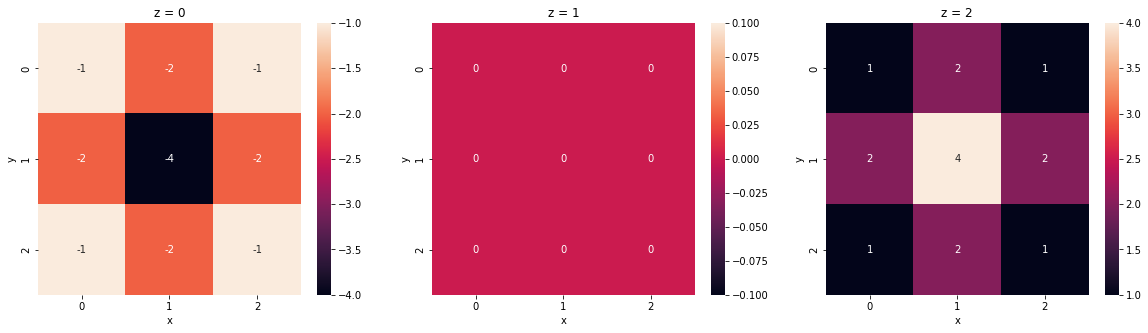

In [ ]:
#@title Compute 3D sobel kernel

def get_3D_sobel_kernel(axis):
  """
    Obtain the 3D sobel kernel for a specific axis.
    Note that the representation for the axis is (z, y, x).
  """
  if type(axis) == str:
    axis = ["z", "y", "x"].index(axis.lower())

  smoothing = np.array([1, 2, 1]).reshape(1, 1, 3)
  deriv = np.array([-1, 0, 1]).reshape(1, 1, 3)

  operands = [deriv if axis == i else smoothing for i in range(3)]

  return np.einsum("zyx, ijk, abc -> xkc", *operands)

plot_3x3_heatmap(get_3D_sobel_kernel(axis=0))

In [ ]:
#@title get_living_mask

def get_living_mask(grid):
  alpha_channel = grid[:, 3, :, :, :].unsqueeze(dim=1)
  return torch.nn.functional.max_pool3d(input=alpha_channel, kernel_size=3, stride=1, padding=1) > 0.1

get_living_mask(torch.zeros(1, CELL_STATE_SIZE, *target.shape[:3])).shape

torch.Size([1, 1, 11, 13, 15])

In [ ]:
#@title make_box_mask

def make_box_mask(shape, min_percent_size=.2, max_percent_size=.6, seed=None):
  if seed is not None:
    torch.manual_seed(seed)

  d, h, w = shape

  shape_tensor = torch.Tensor(shape)

  box_size = ((max_percent_size - min_percent_size) * torch.rand(3) + min_percent_size) * shape_tensor
  half_box_size = np.ceil((box_size / 2)).int()

  box_center = torch.rand(3) * shape_tensor
  box_center = np.floor(box_center).int()

  mask = torch.ones(shape)
  min, max = box_center - half_box_size, box_center + half_box_size
  min = np.clip(min, 0, shape)
  max = np.clip(max, 0, shape)
  mask[min[0]:max[0], min[1]:max[1], min[2]:max[2]] = 0

  return mask, (box_center, min, max - 1)

def make_smart_damage_mask(model, max_tries = 30, seed=None):
  dumb_mask = None
  n_tries = 0

  while n_tries < max_tries:
    dumb_mask, (mask_center, min_mask_coords, max_mask_coords) = make_box_mask(model.shape[:3], seed=seed)

    corner_coordinates = [
      mask_center,
      [min_mask_coords[0], min_mask_coords[1], min_mask_coords[2]],
      [max_mask_coords[0], min_mask_coords[1], min_mask_coords[2]],
      [min_mask_coords[0], max_mask_coords[1], min_mask_coords[2]],
      [min_mask_coords[0], min_mask_coords[1], max_mask_coords[2]],
      [max_mask_coords[0], max_mask_coords[1], min_mask_coords[2]],
      [max_mask_coords[0], min_mask_coords[1], max_mask_coords[2]],
      [min_mask_coords[0], max_mask_coords[1], max_mask_coords[2]],
      [max_mask_coords[0], max_mask_coords[1], max_mask_coords[2]]
    ]
    
    n_tries += 1

    count = 0

    # Check if at least two corners (or the center) of the dumb mask hits a model voxel
    for corner_coord in corner_coordinates:
      if model[tuple(corner_coord)][3] >= 0.1:
        count += 1
      
        if count == 2:
          smart_mask = dumb_mask
          return smart_mask

  return dumb_mask

mask = make_smart_damage_mask(target)
mask = mask.unsqueeze(dim=-1)
tensor = torch.Tensor(target)
is_zero = (mask == 0).squeeze(dim=-1)
A = (tensor[:, :, :, 3] > 0.1).bool()
tensor[is_zero & A] = torch.Tensor([0, 0, 255, .2])
tensor[is_zero & ~A] = torch.Tensor([0, 0, 0, .2])
show_three_visualizer(tensor)

In [ ]:
#@title CellularAutomata3D Definition

class CellularAutomata3D(torch.nn.Module):
  def __init__(self, filters, space_shape, cell_size=CELL_STATE_SIZE, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.cell_size = cell_size
    self.fire_rate = fire_rate
    self.space_shape = space_shape

    # Create Deep model
    final_layer = torch.nn.Conv3d(in_channels=filters, out_channels=cell_size, kernel_size=1)
    torch.nn.init.zeros_(final_layer.weight)
    final_layer.bias.data.fill_(0)

    self.model = torch.nn.Sequential(
      torch.nn.Conv3d(in_channels=64, out_channels=filters, kernel_size=1),
      torch.nn.ReLU(),
      final_layer
    )

    # Precompute sobel kernels
    self.sobel_tensors = []
    
    for axis in range(3):
      sobel_kernel = get_3D_sobel_kernel(axis)
      sobel_tensor = torch.Tensor(sobel_kernel).to(device)

      self.sobel_tensors.append(sobel_tensor)

  def generate_rotation_matrix(self, roll, pitch, yaw):
    Rx = torch.Tensor([[1, 0, 0], [0, np.cos(roll), -np.sin(roll)], [0, np.sin(roll), np.cos(roll)]]).to(device)
    Ry = torch.Tensor([[np.cos(pitch), 0, np.sin(pitch)], [0, 1, 0], [-np.sin(pitch), 0, np.cos(pitch)]]).to(device)
    Rz = torch.Tensor([[np.cos(yaw), -np.sin(yaw), 0], [np.sin(yaw), np.cos(yaw), 0], [0, 0, 1]]).to(device)

    return Rz @ (Ry @ Rx)

  def perceive(self, grid, angles=(0, 0, 0)):
    conv_results = torch.zeros((grid.shape[0], self.cell_size * 4, *self.space_shape), device=device)
    conv_results[:, :16, :, :, :] = grid

    # 3x3 rotation matrix
    R = self.generate_rotation_matrix(*angles)

    # For each axis
    for axis in range(3):
      # Compute the rotated 3D sobel kernel (3x3x3) associated to the current axis
      rotated_conv_kernel = R[axis][0] * self.sobel_tensors[0] + R[axis][1] * self.sobel_tensors[1] + R[axis][2] * self.sobel_tensors[2]

      # Repeat the kernel in order to apply it to each channel independently
      rotated_conv_kernel = rotated_conv_kernel.view(1, 1, 3, 3, 3)
      rotated_conv_kernel = rotated_conv_kernel.repeat(self.cell_size, 1, 1, 1, 1)

      conv_result = torch.nn.functional.conv3d(grid, rotated_conv_kernel, padding="same", groups=self.cell_size)

      conv_results[:, 16 * (axis + 1) : 16 * (axis + 2), :, :, :] = conv_result

    return conv_results
  
  def forward(self, grid, angles=(0, 0, 0), return_delta=False):
    batch_size = grid.shape[0]
    pre_life_mask = get_living_mask(grid)

    y = self.perceive(grid, angles)
    dx = self.model(y)

    update_mask = torch.rand(batch_size, 1, *self.space_shape, device=device) <= self.fire_rate
    updated_grid = grid + dx * update_mask

    post_life_mask = get_living_mask(updated_grid)
    life_mask = pre_life_mask & post_life_mask
    result = updated_grid * life_mask

    if return_delta:
      result = (result, dx)

    return result

In [ ]:
#@title Training Configuration { run: "auto" }

epochs = 3000 #@param
batch_size = 8 #@param
lr = 8e-4 #@param
min_iter = 64 #@param
max_iter = 96 #@param
conv_filters = 128 #@param

#@markdown <br />

use_pool = True #@param {type: "boolean"}
pool_size = 1024 #@param

#@markdown <br />

use_damage = True #@param {type: "boolean"}
num_damages = 3 #@param


params = {"model_name": MODEL_NAME, "epochs": epochs, "batch_size": batch_size, "lr": lr, "min_iter": min_iter, "max_iter": max_iter, "conv_filters": conv_filters, "use_pool": use_pool, "pool_size": pool_size, "use_damage": use_damage, "num_damages": num_damages}

In [ ]:
# Mount GDrive for training checkpoints
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#@title Start run
run_type = "Resume run" #@param ["Resume run", "New run"]

def load_model_from_drive(run_id, models_dir="Tests"):
  # Since some models don't have the optimizer state, avoid loading a mismatched optimizer
  if os.path.exists("optimizer.pt"):
    os.remove("optimizer.pt")
  
  target_path = os.path.join(models_dir, model_id + ".zip")

  # Extract all
  with ZipFile(target_path, "r") as zip:
      zip.extractall(".")

  # Load params
  with open("params.json", "r") as f:
    params = json.load(f)

  # Load model
  ca_model = CellularAutomata3D(params["conv_filters"], target.shape[:3])
  ca_model.load_state_dict(torch.load("model.pt", map_location=device))
  ca_model.to(device)

  # Load optimizer
  optimizer = None
  if os.path.exists("optimizer.pt"):
    optimizer = torch.optim.Adam(ca_model.parameters(), lr=params["lr"])
    optimizer.load_state_dict(torch.load("optimizer.pt", map_location=device))

  # Load pool
  pool = torch.load("pool.pt", map_location=device)
  pool_losses = torch.load("pool_losses.pt", map_location=device)

  return ca_model, params, optimizer, pool

if run_type != "New run":
  print("Insert the model_id to resume:")
  model_id = input()

  ca_model, params, optimizer, pool = load_model_from_drive(model_id)

  initial_epoch = params["epoch"] + 1
  epochs = params["epochs"]
  batch_size = params["batch_size"]
  lr = params["lr"]
  min_iter = params["min_iter"]
  max_iter = params["max_iter"]
  conv_filters = params["conv_filters"]
  use_pool = params["use_pool"]
  pool_size = params["pool_size"]
  use_damage = params["use_damage"]
  num_damages = params["num_damages"]

  print("Model", model_id, "loaded in ca_model, the target for this model is", params["model_name"], "\n")

  print("Params:")
  for param in params:
    print(param, "->", params[param])
else:
  ca_model = CellularAutomata3D(conv_filters, space_shape=target.shape[:3]).to(device)
  model_id = uuid.uuid4()
  initial_epoch = 0
  print("Created new model with id", model_id)

Insert the model_id to resume:
4420bb01-ea35-44ce-8cef-aceac12ddcd7
Model 4420bb01-ea35-44ce-8cef-aceac12ddcd7 loaded in ca_model, the target for this model is Minecraft Cow 

Params:
model_name -> Minecraft Cow
epochs -> 3000
batch_size -> 8
lr -> 0.0008
min_iter -> 64
max_iter -> 96
conv_filters -> 128
use_pool -> True
pool_size -> 1024
use_damage -> True
num_damages -> 3
epoch -> 2999


In [ ]:
#@title Training
shape = target.shape[:3]
seed = np.zeros([*shape, 16], np.float32)
seed[shape[0]//2, shape[1]//2, shape[2]//2, 3:] = 1

seed_tensor = torch.Tensor(seed)
seed_tensor = norm_rgb(seed_tensor).to(device)
target_tensor = torch.Tensor(target)
target_tensor = norm_rgb(target_tensor).to(device)

if run_type == "New run" or optimizer is None:
  optimizer = torch.optim.Adam(ca_model.parameters(), lr=lr)
criterion = torch.nn.MSELoss(reduction="none")

def train_step(x, target, iter_n):

  for i in range(iter_n):
    x = ca_model(x)

  individual_loss = criterion(x[:, :4, :, :, :], target[:, :4, :, :, :])
  
  batch_loss = individual_loss.mean(dim=(1, 2, 3, 4))
  loss = batch_loss.mean()

  optimizer.zero_grad()
  loss.backward()

  for param in ca_model.parameters():
    param.grad /= torch.norm(param.grad) + 1e-8

  optimizer.step()

  return x, loss, batch_loss

# Initialize pool with seeds and relative losses
pool = seed_tensor.repeat(pool_size, 1, 1, 1, 1)
pool_losses = np.ones(pool_size) * np.inf

losses = []
# pool_history = []
batches = []

training_progress = []

# Train the model
for epoch in trange(initial_epoch, epochs):
  start = time.time()

  # if epoch % int(epochs // 10) == 0:
  #   pool_history.append(pool.clone())
  
  if use_pool:
    # Sample batch_size initial states from the pool
    pool_idxs = np.random.choice(np.arange(pool_size), batch_size, replace=False)
    x_batch = pool[pool_idxs]

    # Replace sample with highest loss with initial seed
    loss_batch_idx = np.argsort(pool_losses[pool_idxs])

    x_batch[loss_batch_idx[-1]] = seed_tensor.clone()

    if use_damage:
      # Damage samples with the lowest loss
      for sample in x_batch[loss_batch_idx[:3]]:
        mask = make_smart_damage_mask(target).unsqueeze(dim=-1).to(device)
        # mask, _ = make_box_mask(target.shape[:3])
        # mask = mask.unsqueeze(dim=-1).to(device)
        sample *= mask
      
      if epoch % 10 == 0:
       batches.append(x_batch.cpu().detach())
  else:
    x_batch = seed_tensor.repeat(batch_size, 1, 1, 1, 1)
  
  target_batch = target_tensor.repeat(batch_size, 1, 1, 1, 1)
  
  x_batch = torch.einsum("bdhwc -> bcdhw", x_batch)
  target_batch = torch.einsum("bdhwc -> bcdhw", target_batch)

  iter_n = np.random.randint(min_iter, max_iter)

  x, loss, batch_loss = train_step(x_batch, target_batch, iter_n)

  if use_pool:
    pool_losses[pool_idxs] = batch_loss.cpu().detach().numpy()
    pool[pool_idxs] = torch.einsum("bcdhw -> bdhwc", x.detach())

  losses.append(loss)

  print("Epoch: {} Iterations: {} Loss: {:.04f} Memory: {} Time: {:.02f} secs".format(epoch, iter_n, loss, get_allocated_memory(), time.time() - start))

  # Save model state
  if (epoch + 1) % 10 == 0:
    save_model_state(model_id, epoch, params, ca_model, optimizer, losses, pool, pool_losses)

  0%|          | 0/1840 [00:00<?, ?it/s]

Epoch: 1160 Iterations: 73 Loss: 0.0300 Memory: 829.86 MB Time: 3.05 secs
Epoch: 1161 Iterations: 84 Loss: 0.0246 Memory: 830.83 MB Time: 2.87 secs
Epoch: 1162 Iterations: 90 Loss: 0.0238 Memory: 829.86 MB Time: 3.07 secs
Epoch: 1163 Iterations: 69 Loss: 0.0366 Memory: 830.83 MB Time: 2.35 secs
Epoch: 1164 Iterations: 86 Loss: 0.0236 Memory: 829.86 MB Time: 2.95 secs
Epoch: 1165 Iterations: 93 Loss: 0.0205 Memory: 829.86 MB Time: 3.22 secs
Epoch: 1166 Iterations: 84 Loss: 0.0249 Memory: 829.86 MB Time: 2.90 secs
Epoch: 1167 Iterations: 69 Loss: 0.0319 Memory: 829.86 MB Time: 2.39 secs
Epoch: 1168 Iterations: 75 Loss: 0.0274 Memory: 829.86 MB Time: 2.59 secs
Epoch: 1169 Iterations: 94 Loss: 0.0219 Memory: 829.86 MB Time: 3.29 secs
Saved model 4420bb01-ea35-44ce-8cef-aceac12ddcd7 state at epoch 1169
Epoch: 1170 Iterations: 81 Loss: 0.0246 Memory: 829.86 MB Time: 2.94 secs
Epoch: 1171 Iterations: 85 Loss: 0.0226 Memory: 829.86 MB Time: 2.97 secs
Epoch: 1172 Iterations: 80 Loss: 0.0236 Mem

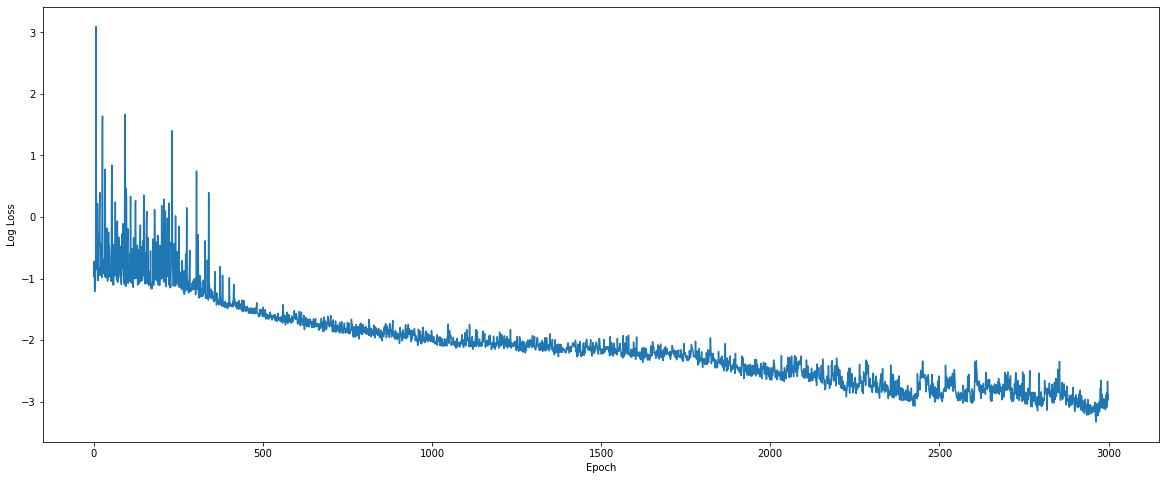

In [ ]:
#@title Plot log loss
plt.figure(figsize=(20, 8))
plt.plot(range(len(losses)), np.log10([loss.cpu().detach().numpy() for loss in losses]))
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.show()

# Visualization

In [ ]:
#@title Load pretrained model
SHAPE_NAME = "Splash" #@param ["Box with cross", "Colored", "Dino", "Snake", "Minecraft Pig", "Minecraft Cow", "Minecraft Chicken", "Minecraft Dog", "Tower", "Splash"]
model_path = SHAPE_NAME + ".vox"
# "1-2LtmTD3JtXSfGSZf6C29P6bVW5f8gvm"
output = download_from_drive(model_path, DRIVE_SHAPES_ID[SHAPE_NAME], unzip=False)
print("Shape downloaded in", output)

voxels, palette = load_voxel_mesh(model_path)
print("Loaded voxel mesh with {} voxels".format(len(voxels)))
target = make_voxel_grid_center(voxels, palette, padding=2)
print("Generated voxel grid of shape", target.shape)

def load_pretrained_model(shape, target):
  gdrive_id = DRIVE_PRETRAINED_MODELS_ID[shape]
  target_path = download_from_drive(normalize_shape_name(shape) + ".zip", gdrive_id)

  # Extract all
  with ZipFile(target_path, "r") as zip:
      zip.extractall(".")

  # Load params
  with open("params.json", "r") as f:
    params = json.load(f)

  # Load model
  ca_model = CellularAutomata3D(params["conv_filters"], target.shape[:3])
  model_weights = torch.load("model.pt", map_location=device)
  ca_model.load_state_dict(model_weights)
  ca_model.to(device)

  return ca_model

ca_model = load_pretrained_model(SHAPE_NAME, target)
print("Loaded model", SHAPE_NAME, "in ca_model")


Splash.vox already downloaded.
Shape downloaded in Splash.vox
Loaded voxel mesh with 161 voxels
Generated voxel grid of shape (11, 13, 15, 4)
Loaded model Splash in ca_model


In [ ]:
#@title Visualize run
n_iter = 500 #@param
n_samples = 100 #@param

#@markdown <br />

damage_target = False #@param { type: "boolean" }

#@markdown <br />
#@markdown Angles should be expressed in radiants

angle_x =  0#@param
angle_y =  0#@param
angle_z =  0#@param

#@markdown <br />

show_only_last_iter = False #@param {type: "boolean"}

def generate_run(target, ca_model, damage_target=False, n_iter=200, n_samples=200, angle_x=0, angle_y=0, angle_z=0, seed=None):
  shape = target.shape[:3]

  x = torch.zeros(*shape, 16)
  
  if angle_x:
    target = ndimage.rotate(target.copy(), np.degrees(-angle_x), axes=(1, 2), reshape=False, order=0)

  if angle_y:
    target = ndimage.rotate(target.copy(), np.degrees(-angle_y), axes=(0, 2), reshape=False, order=0)

  if angle_z:
    target = ndimage.rotate(target.copy(), np.degrees(angle_z), axes=(0, 1), reshape=False, order=0)
  
  target_tensor = torch.Tensor(target)

  if damage_target:
    mask = make_smart_damage_mask(target, seed=seed).unsqueeze(dim=-1)
    result = target_tensor * mask

    x[:, :, :, :4] = result
  else:
    x[shape[0]//2, shape[1]//2, shape[2]//2, 3:] = 1

  x = norm_rgb(x)
  x = x.repeat(1, 1, 1, 1, 1)
  x = torch.einsum("bdhwc -> bcdhw", x)
  x = x.to(device)

  criterion = torch.nn.MSELoss(reduction="none")

  target_tensor = norm_rgb(target_tensor)
  target_tensor = torch.einsum("dhwc -> cdhw", target_tensor)
  target_tensor = target_tensor[:4, :, :, :]
  target_tensor = torch.unsqueeze(target_tensor, dim=0)
  target_tensor = target_tensor.to(device)

  new_run = []
  mse_losses = []
  for i in trange(n_iter):

    if i % int(n_iter / n_samples) == 0:
      sample = x[0].cpu().detach().numpy()
      sample = np.einsum("cdhw -> dhwc", sample)
      new_run.append(denorm_rgb(sample))

    x = ca_model(x, angles=(angle_x, angle_y, angle_z))

    individual_loss = criterion(x[:, :4, :, :, :], target_tensor)
    
    batch_loss = individual_loss.mean(dim=(1, 2, 3, 4))
    loss = batch_loss.mean()

    mse_losses.append(loss.cpu().detach())

  new_run = np.array(new_run)
  return new_run, mse_losses

new_run, mse_losses = generate_run(target, ca_model, damage_target=damage_target, n_iter=n_iter, n_samples=n_samples, angle_x=angle_x, angle_y=angle_y, angle_z=angle_z)
show_three_visualizer(new_run[-1] if show_only_last_iter else new_run)

  0%|          | 0/500 [00:00<?, ?it/s]

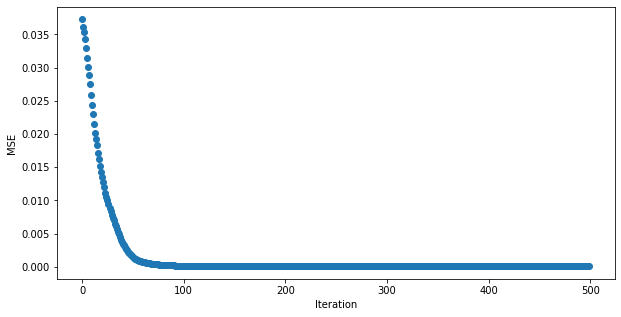

In [ ]:
#@title Show MSE during iterations 
plt.figure(figsize=(10, 5))
plt.scatter(range(len(mse_losses)), [l.cpu().detach() for l in mse_losses])
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.show()

Figure saved in splash.svg


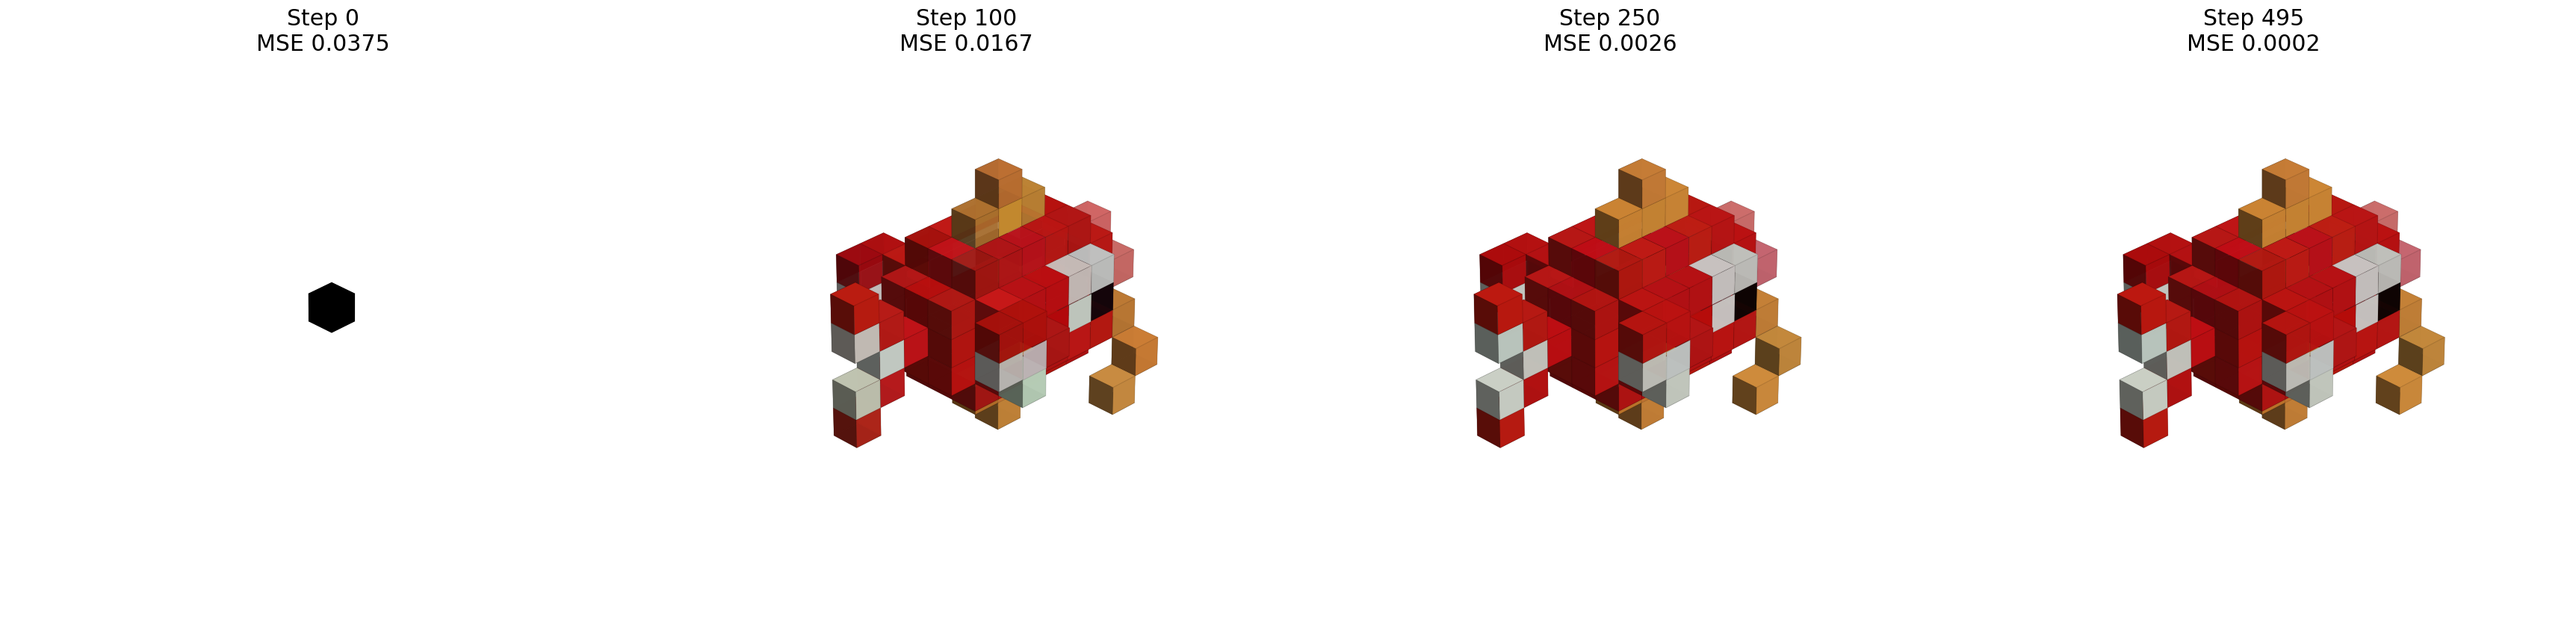

In [ ]:
#@title Plot steps with MSE

def plot_step(ax, target, grid, iteration, mse, camera_distance=8, azim=-45):
    # Swap y and x axis for correct visualization
    colored_voxels = np.einsum("zyxc -> zxyc", grid)
    voxel_array = colored_voxels[:, :, :, 3] > .1
    
    original_colors = colored_voxels[:, :, :, :4].copy()
    original_colors[:, :, :, :3] = original_colors[:, :, :, :3] / 255
    original_colors = np.clip(original_colors, 0.0, 1.0)

    ax.set_title(f"Step {iteration}\nMSE {mse:.4f}", fontsize=30)
    ax.view_init(elev=30, azim=azim)
    ax.dist = camera_distance
    ax.axis("off")
    ax.voxels(voxel_array, facecolors=original_colors, edgecolor=[0, 0, 0, .1], lightsource=LightSource(azdeg=30, altdeg=30))

    # Make voxels cubic, mantaining aspect ratio
    max_lim = max(target.shape)

    current_min, current_max = ax.get_xlim()
    delta = max_lim - (current_max - current_min)
    ax.set_xlim(current_min - (delta / 2), current_max + (delta / 2))

    current_min, current_max = ax.get_ylim()
    delta = max_lim - (current_max - current_min)
    ax.set_ylim(current_min - (delta / 2), current_max + (delta / 2))

    current_min, current_max = ax.get_zlim()
    delta = max_lim - (current_max - current_min)
    ax.set_zlim(current_min - (delta / 2), current_max + (delta / 2))


def plot_steps(target, run, mse_losses, steps, save_fig=None, size=9, camera_distance=8, azim=-45):
  """
  Plot the output of the model at some specified steps including the MSE loss.
  """
  ncols = len(steps)
  samples = len(run)
  
  fig = plt.figure(figsize=(size * ncols, size))
  fig.set_facecolor("w")
  gs = gridspec.GridSpec(1, ncols)

  for i, step in enumerate(steps):
    grid = run[step]
    iteration = step * n_iter // samples
    mse = mse_losses[step]

    ax = plt.subplot(gs[i], projection="3d")
    plot_step(ax, target, grid, iteration, mse, camera_distance, azim)

  plt.tight_layout()

  plt.savefig(save_fig)

steps = [0, 20, 50, 99] #@param
fig_name = normalize_shape_name(SHAPE_NAME) + ".svg"
plot_steps(target, new_run, mse_losses, steps, save_fig=fig_name, size=12, camera_distance=7)
print("Figure saved in", fig_name)

In [ ]:
#@title Generate video

def generate_video_frames(target, run, mse_losses, n_iter, camera_distance=8):
  # Remove already existing frames
  if os.path.exists("frames"):
    shutil.rmtree("frames")
  os.mkdir("frames")

  figsize = (9, 12)
  azim = -45
  samples = len(run)

  for index, iter in enumerate(tqdm(run)):
    mse = mse_losses[index]

    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    ax0 = plt.subplot(gs[0], projection="3d")
    iteration = index * n_iter // samples
    plot_step(ax0, target, iter, iteration, mse, camera_distance, azim=azim)
    
    title = f"Step: {iteration}"
    ax0.set_title(title)
    
    ax1 = plt.subplot(gs[1])
    current_mse_losses = mse_losses[:iteration]
    ax1.plot(range(len(current_mse_losses)), current_mse_losses)
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("MSE")

    plt.savefig(os.path.join("frames", f"frame_{index}.png"))

    azim += 360 / len(run)
    azim = azim % 360

    plt.close()

def save_video_to_disk(output_video_name, src_folder="frames"):
  print("Loading frames from disk")
  frames = []

  for index in trange(len(os.listdir(src_folder))):
    frame_path = os.path.join(src_folder, f"frame_{index}.png")
    frame = cv2.imread(frame_path)
    frames.append(frame)

  print("Writing output video: ", output_video_name)
  out = cv2.VideoWriter(output_video_name, cv2.VideoWriter_fourcc(*"mp4v"), 20.0, (frames[0].shape[1], frames[0].shape[0]))

  for frame in tqdm(frames):
    out.write(frame)

  out.release()

generate_video_frames(target, new_run, mse_losses, 500, camera_distance=8)

# Save video to disk
output_video_name = normalize_shape_name(SHAPE_NAME) + ".mp4"
save_video_to_disk(output_video_name)

# Show video in Colab
VideoFileClip(output_video_name).ipython_display(width=430)

  0%|          | 0/100 [00:00<?, ?it/s]

Loading frames from disk


  0%|          | 0/100 [00:00<?, ?it/s]

Writing output video:  splash.mp4


  0%|          | 0/100 [00:00<?, ?it/s]

 99%|█████████▉| 100/101 [00:00<00:00, 162.37it/s]


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

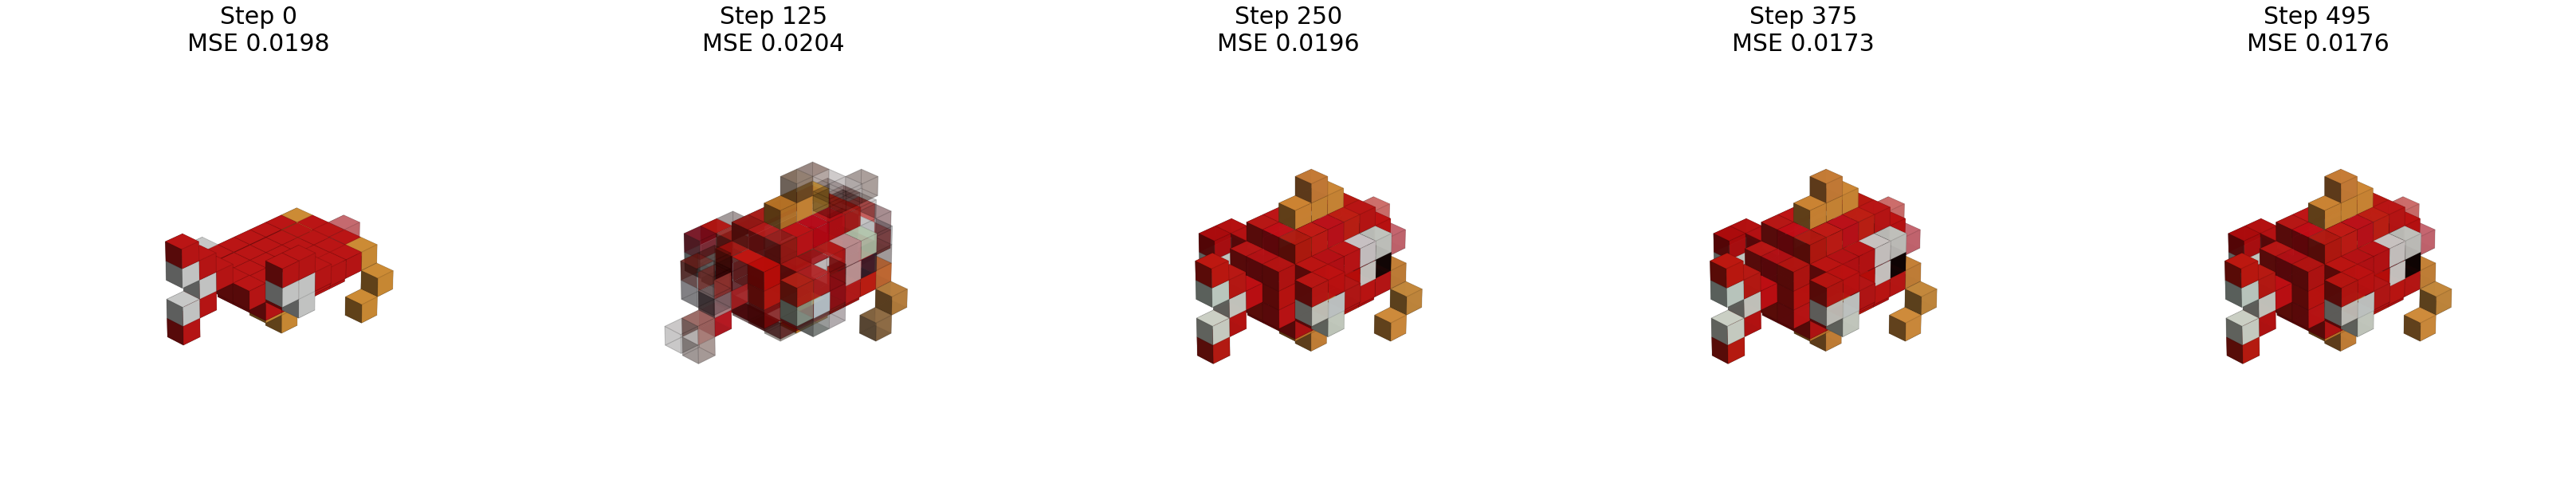

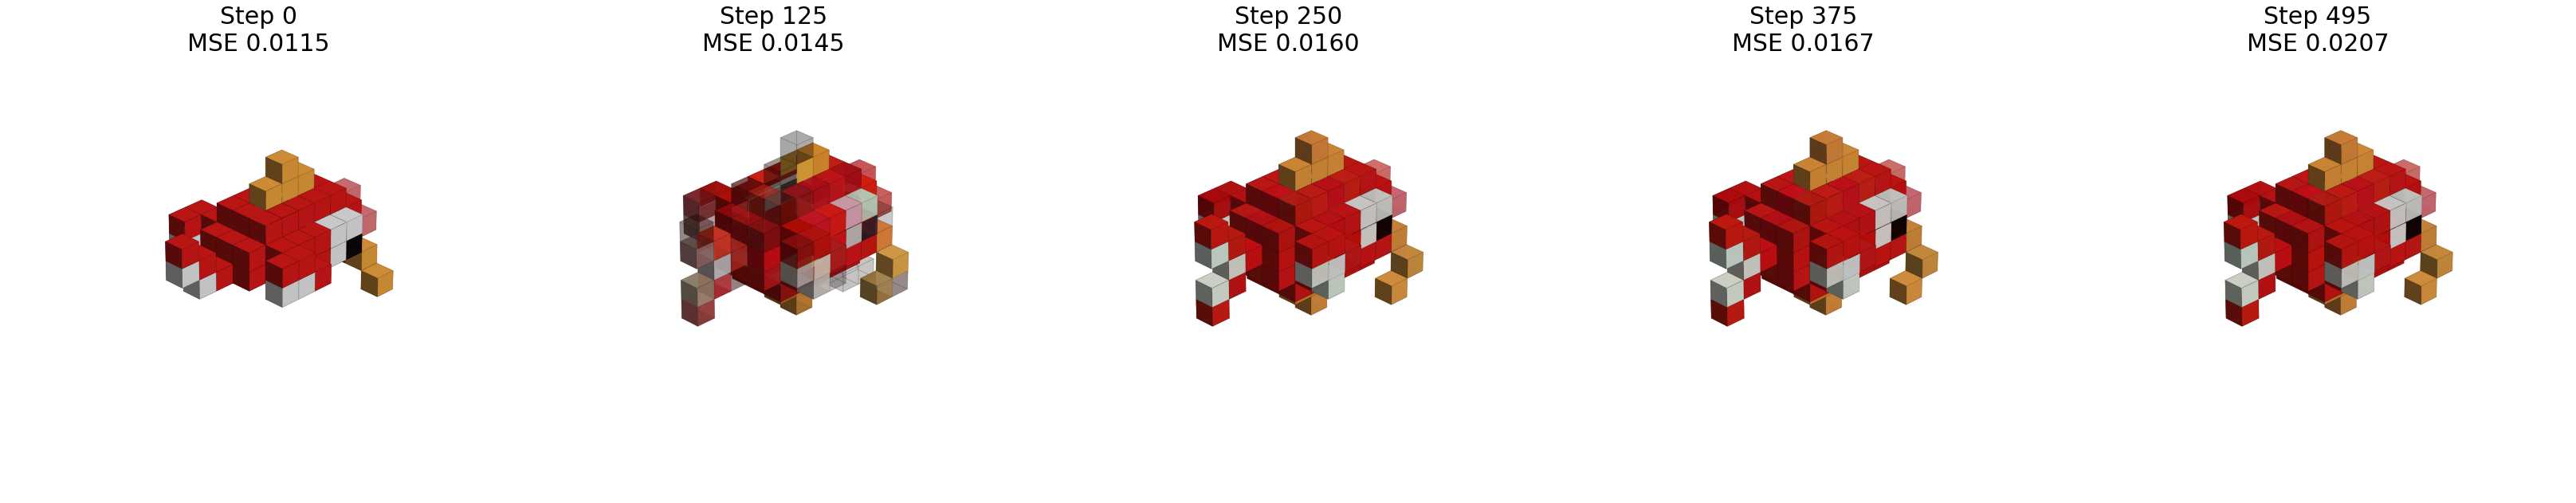

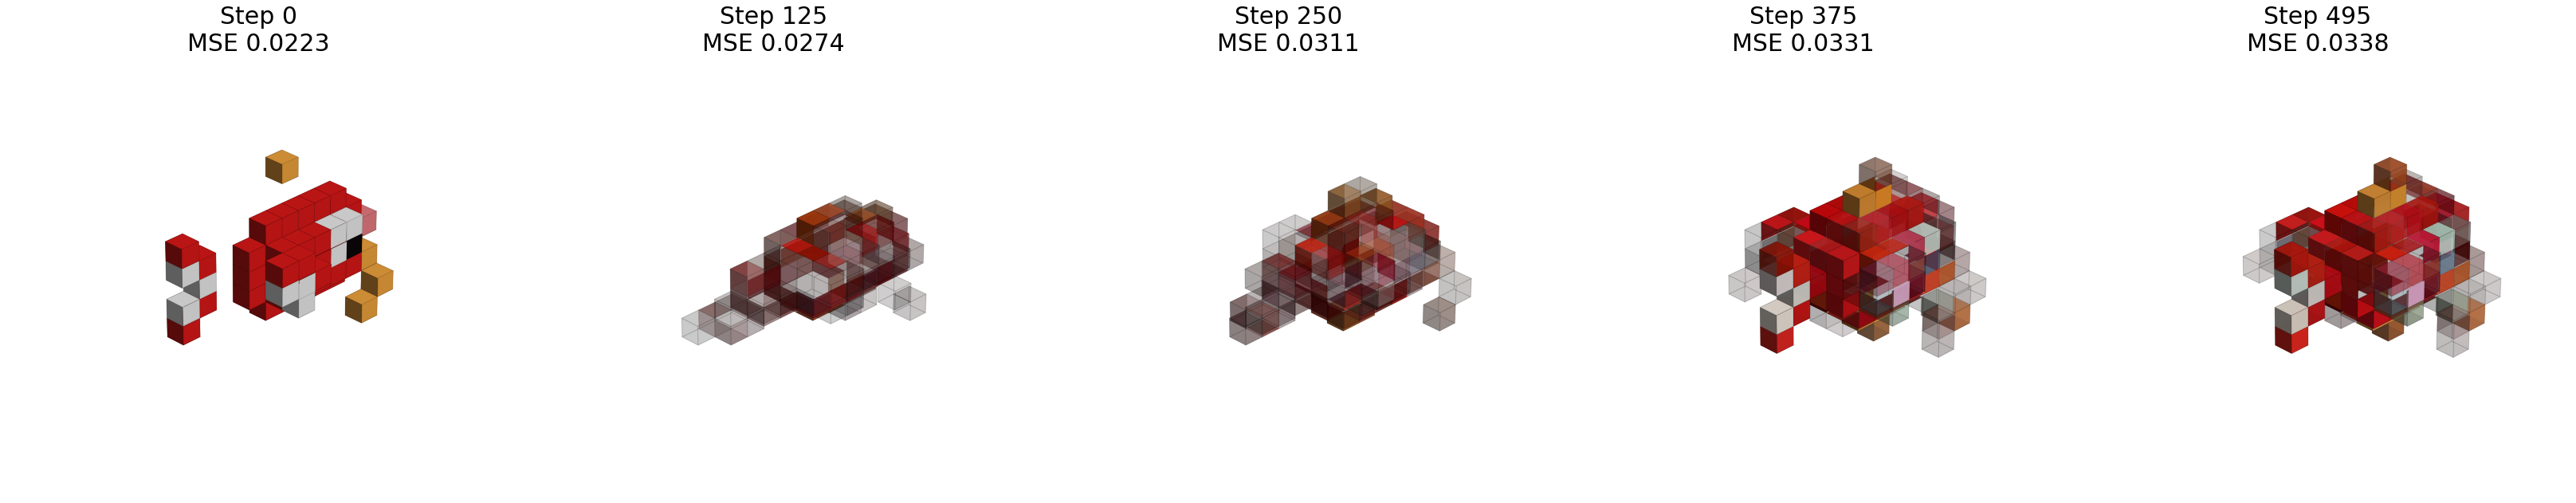

In [ ]:
#@title Evaluate damage

damage_seeds = {
  "Box with cross": [2, 6, 7],
  "Colored": [0, 2, 6],
  "Dino": [1, 2, 8], 
  "Snake": [2, 6, 12], 
  "Minecraft Pig": [2, 5, 6], 
  "Minecraft Cow": [2, 5, 15],
  "Minecraft Chicken": [1, 2, 5],
  "Minecraft Dog": [5, 1, 2],
  "Tower": [2, 6, 8],
  "Splash": [2, 6, 8]
}

def evaluate_damage(shape_name, target, model, seeds):
  for seed in seeds:
    run, losses = generate_run(target, model, damage_target=True, n_iter=500, n_samples=100, seed=seed)
    filename = normalize_shape_name(shape_name) + "_damage_" + str(seed) + ".png"
    plot_steps(target, run, losses, [0, 25, 50, 75, 99], save_fig=filename)

evaluate_damage(SHAPE_NAME, target, ca_model, damage_seeds[SHAPE_NAME]) 


# Additional material generation

  0%|          | 0/36 [00:00<?, ?it/s]

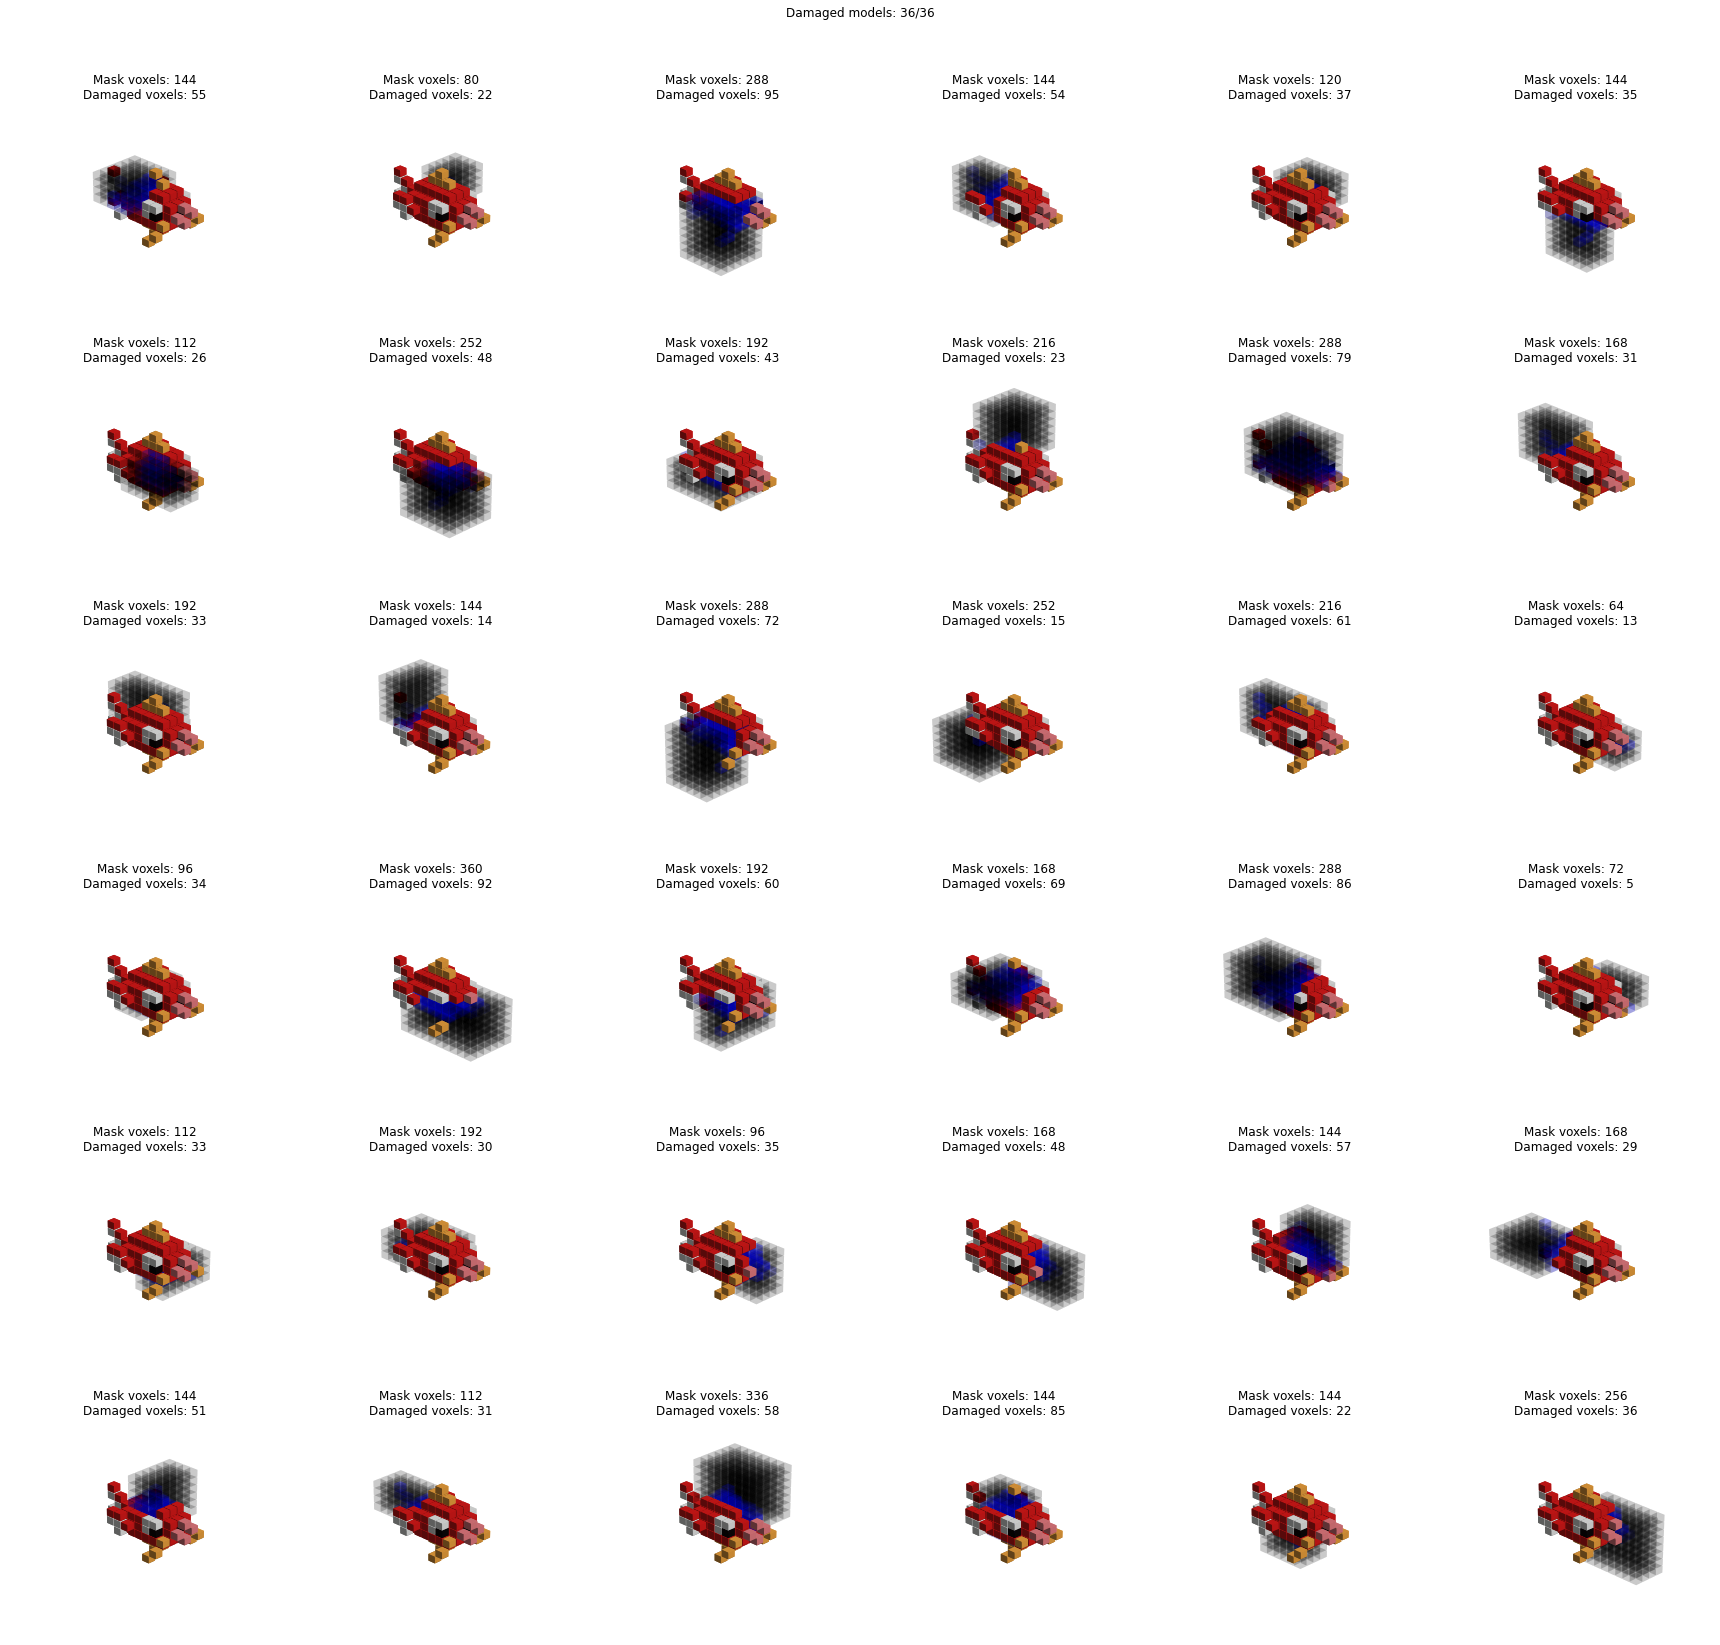

In [ ]:
#@title Damage visualization
num_examples = 36 #@param {type: "integer"}
size = 4
nrows = np.ceil(np.sqrt(num_examples))
ncols = np.ceil(np.sqrt(num_examples))

fig = plt.figure(figsize=(size * ncols, size * nrows))
damaged_count = 0
for i in trange(num_examples):
  mask = make_smart_damage_mask(target)
  mask = mask.unsqueeze(dim=-1)
  tensor = torch.Tensor(target)
  is_zero = (mask == 0).squeeze(dim=-1)
  A = (tensor[:, :, :, 3] > 0.1).bool()
  tensor[is_zero & A] = torch.Tensor([0, 0, 255, .2])
  tensor[is_zero & ~A] = torch.Tensor([0, 0, 0, .11])
  tensor[:, :, :, :3] /= 255.

  ax = fig.add_subplot(nrows, ncols, i + 1, projection="3d")
  tensor = np.einsum("zyxc -> xzyc", tensor)
  plot_voxels_matplotlib(tensor, ax=ax, render_internal_voxels=True)
  mask_voxels = (mask == 0).sum().item()
  damaged_voxels = (is_zero & A).sum().item()
  ax.set_title("Mask voxels: " + str(mask_voxels) + "\nDamaged voxels: " + str(damaged_voxels))

  if damaged_voxels > 0:
    damaged_count += 1
plt.suptitle("Damaged models: {}/{}".format(damaged_count, num_examples))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

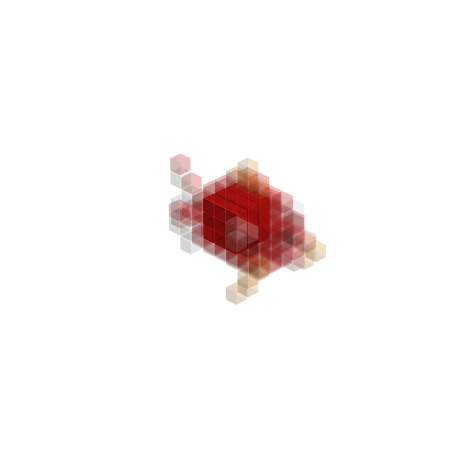

In [ ]:
#@title Convolution kernel

show_target = target.copy()
show_target = np.einsum("zyxc -> xzyc", show_target)
show_target[:, :, :, :3] /= 255
center = (np.array(show_target.shape) - 1) // 2

voxels = show_target[:, :, :, 3] > 0.1
show_target[voxels, 3] = 0.15
show_target[center[0]-1:center[0]+2, center[1]-1:center[1]+2, center[2]-1:center[2]+2, 3] = 1

edgecolors = np.zeros_like(show_target[:, :, :, :4])
edgecolors[center[0]-1:center[0]+2, center[1]-1:center[1]+2, center[2]-1:center[2]+2, 3] = .2

plot_voxels_matplotlib(show_target, edgecolors=edgecolors, render_internal_voxels=True, figsize=(8, 8))

  0%|          | 0/35 [00:00<?, ?it/s]

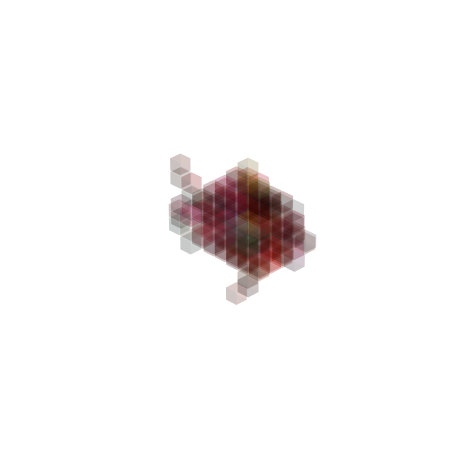

In [ ]:
#@title Model Update
step = 35 #@param

shape = target.shape[:3]

x = torch.zeros(*shape, 16)
x[shape[0]//2, shape[1]//2, shape[2]//2, 3:] = 1
x = norm_rgb(x)
x = x.repeat(1, 1, 1, 1, 1)
x = torch.einsum("bdhwc -> bcdhw", x)
x = x.to(device)

samples = []
for i in trange(step):
    x, delta = ca_model(x, return_delta=True)

    sample = delta[0].cpu().detach().numpy()
    sample = np.einsum("cdhw -> dhwc", sample)

    # Make changes visible by increasing alpha over 0.1
    voxels = x[0, 3, :, :, :].cpu().detach().numpy() > 0.1 
    changes = np.sum(target[:, :, :, :4], axis=-1) > 0
    not_visibles = sample[:, :, :, 3] < 0.1
    sample[voxels & changes & not_visibles, 3] = 0.11

    # Increase colors and alpha for better visualization
    sample[:, :, :, :3] *= 10
    sample[:, :, :, 3] *= 1.3
    samples.append(sample)

show_target = samples[-1].copy()
show_target = np.einsum("zyxc -> xzyc", show_target)
show_target = np.clip(show_target, 0, 1)

voxels = show_target[:, :, :, 3] > 0.1

facecolors = show_target[:, :, :, :4].copy()

edgecolors = np.zeros_like(facecolors)
edgecolors[:, :, :, 3] = 0.2

plot_voxels_matplotlib(show_target, edgecolors=edgecolors, figsize=(8, 8), render_internal_voxels=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Box with cross.vox already downloaded.
box_with_cross.zip already downloaded.


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Minecraft Cow.vox already downloaded.


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

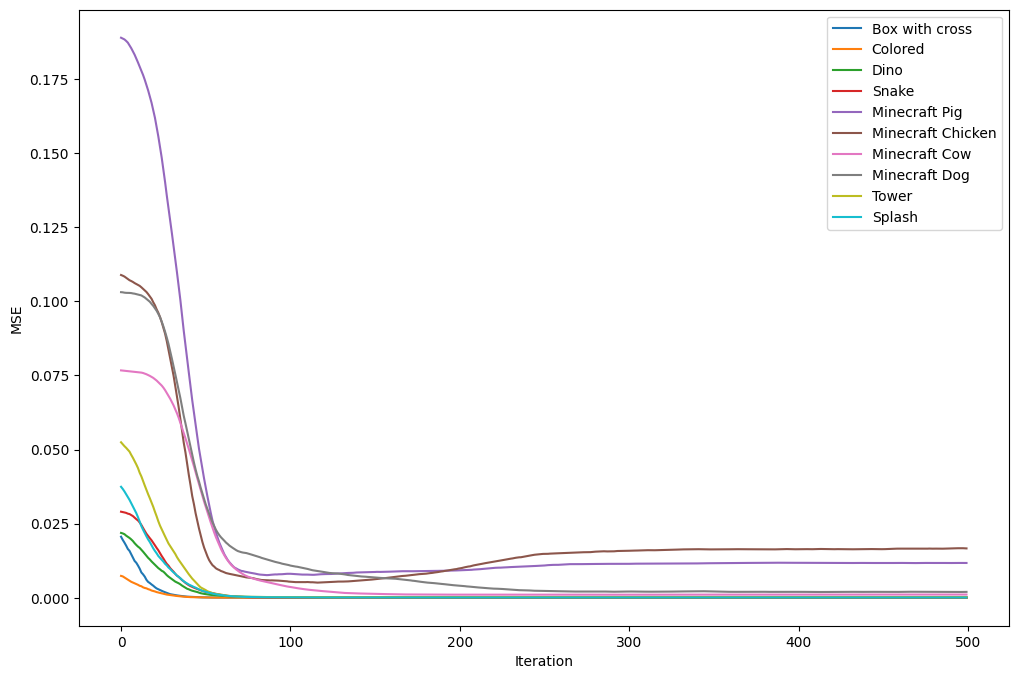

Saved plot in mse_models.pdf


In [ ]:
#@title Generate MSE plot

plt.figure(figsize=(12, 8))
plt.xlabel("Iteration")
plt.ylabel("MSE")

n_iter = 500
n_samples = 100

for shape_name, model_id in tqdm(SAVED_MODELS_ID.items()):
  model_path = shape_name + ".vox"
  output = download_from_drive(model_path, DRIVE_SHAPES_ID[shape_name], unzip=False)
  voxels, palette = load_voxel_mesh(model_path)

  target = make_voxel_grid_center(voxels, palette, padding=2)

  ca_model = load_pretrained_model(shape_name, target)

  new_run, mse_losses = generate_run(target, ca_model, damage_target=False, n_iter=n_iter, n_samples=n_samples, angle_x=0, angle_y=0, angle_z=0)

  plt.plot(range(len(mse_losses)), mse_losses, label=shape_name)

plt.legend()

plt.savefig("mse_models.pdf")
plt.show()

print("Saved plot in mse_models.pdf")

In [ ]:
#@title Generate videos

import gc

shapes = [
    "Box with cross",
    "Colored",
    "Dino",
    "Snake",
    "Minecraft Pig",
    "Minecraft Chicken",
    "Minecraft Cow",
    "Minecraft Dog",
    "Tower",
    "Splash"
]

def generate_all_videos(n_iter, n_samples, shapes=None):
  if shapes is None:
    shapes = DRIVE_SHAPES_ID.keys()

  for shape_name in tqdm(shapes):
    drive_id = DRIVE_SHAPES_ID[shape_name]
    model_path = shape_name + ".vox"
    output = download_from_drive(model_path, drive_id, unzip=False)
    voxels, palette = load_voxel_mesh(model_path)

    target = make_voxel_grid_center(voxels, palette, padding=2)

    ca_model = load_pretrained_model(shape_name, target)

    video_name = normalize_shape_name(shape_name) + "_normal.mp4"
    new_run, mse_losses = generate_run(target, ca_model, damage_target=False, n_iter=n_iter, n_samples=n_samples, angle_x=0, angle_y=0, angle_z=0)
    generate_video_frames(target, new_run, mse_losses, n_iter, camera_distance=8)
    save_video_to_disk(video_name)

    del new_run
    gc.collect()
    
    video_name = normalize_shape_name(shape_name) + "_damage.mp4"
    seed = damage_seeds[shape_name][2]
    new_run, mse_losses = generate_run(target, ca_model, damage_target=True, n_iter=n_iter, n_samples=n_samples, angle_x=0, angle_y=0, angle_z=0, seed=seed)
    generate_video_frames(target, new_run, mse_losses, n_iter, camera_distance=8)
    save_video_to_disk(video_name)

    del new_run
    gc.collect()

    video_name = normalize_shape_name(shape_name) + "_rotate.mp4"
    new_run, mse_losses = generate_run(target, ca_model, damage_target=False, n_iter=n_iter, n_samples=n_samples, angle_x=np.pi/2, angle_y=0, angle_z=0)
    generate_video_frames(target, new_run, mse_losses, n_iter, camera_distance=8)
    save_video_to_disk(video_name)

    del new_run, ca_model
    plt.close("all")
    gc.collect()

generate_all_videos(n_iter=500, n_samples=100, shapes=shapes)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Loading frames from disk


  0%|          | 0/100 [00:00<?, ?it/s]

Writing output video:  tower_normal.mp4


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Loading frames from disk


  0%|          | 0/100 [00:00<?, ?it/s]

Writing output video:  tower_damage.mp4


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Loading frames from disk


  0%|          | 0/100 [00:00<?, ?it/s]

Writing output video:  tower_rotate.mp4


  0%|          | 0/100 [00:00<?, ?it/s]

Splash.vox already downloaded.
splash.zip already downloaded.


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Loading frames from disk


  0%|          | 0/100 [00:00<?, ?it/s]

Writing output video:  splash_normal.mp4


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Loading frames from disk


  0%|          | 0/100 [00:00<?, ?it/s]

Writing output video:  splash_damage.mp4


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Loading frames from disk


  0%|          | 0/100 [00:00<?, ?it/s]

Writing output video:  splash_rotate.mp4


  0%|          | 0/100 [00:00<?, ?it/s]